## Challenge 3 (4 points) -- Intermediate

* Use the data file "challenge3.gwf" with channel "H1:CHALLENGE3"
* These are real LIGO data from O2, though we've adjusted the time labels and 
  added some simulated signals.
* The data contain a loud simulated signal with m1 = m2 = 10 solar masses.

1. What is the merger time of this signal?

2. What is the matched-filter SNR of this signal?

In [3]:
# ! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge3_2048hz.gwf

--2023-05-24 06:55:56--  https://dcc.ligo.org/public/0187/G2300818/001/challenge3_2048hz.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128414228 (122M)
Saving to: ‘challenge3_2048hz.gwf’

challenge3_2048hz.g 100%[===================>] 122.46M   955KB/s    in 2m 14s  

2023-05-24 06:58:12 (933 KB/s) - ‘challenge3_2048hz.gwf’ saved [128414228/128414228]



In [1]:
from pycbc.frame import read_frame
ts = read_frame("challenge3_2048hz.gwf", "H1:CHALLENGE3")


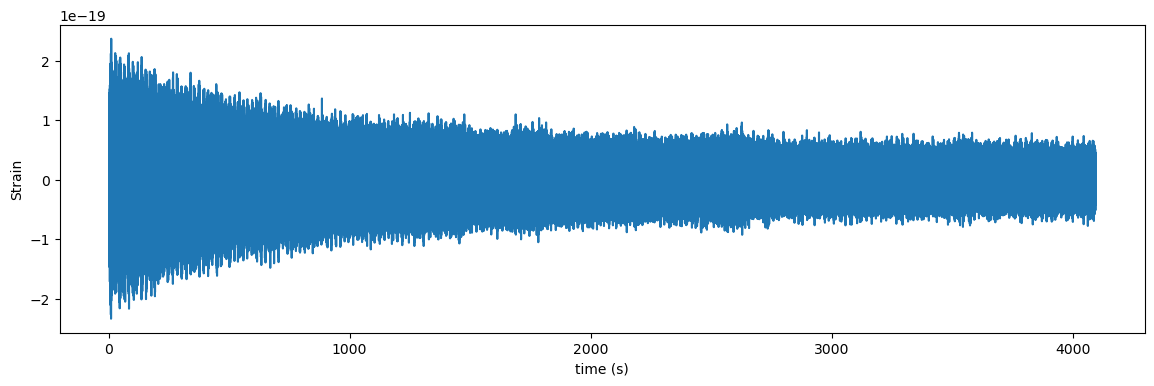

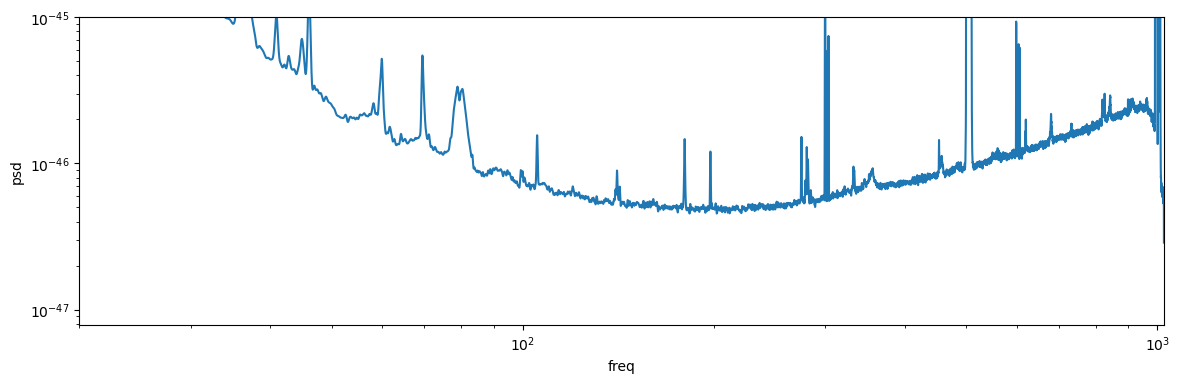

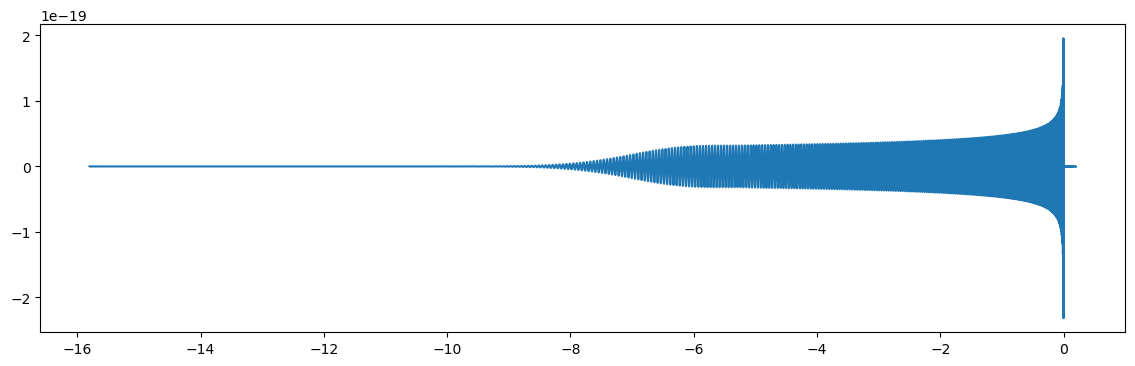

-15.8


In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14,4]
from pycbc.filter import matched_filter, highpass, resample_to_delta_t
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation

# template masses
mass = 10 # Solar masses
spin = 0

# #TODO: Read data
# Remove the low frequency content and downsample the data to 2048Hz,
# also, cropped the numerical artifact
ts = highpass(ts, 15.0)
ts = resample_to_delta_t(ts, 1.0/2048)
ts = ts.crop(2,2)
plt.plot(ts.sample_times, ts)
plt.xlabel("time (s)")
plt.ylabel("Strain")
plt.show()

#TODO: Estimate the power spectral density
# We use 4 second samples of our time series in Welch method.
psd = ts.psd(4)
psd = interpolate(psd, ts.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * ts.sample_rate), 
                                  low_frequency_cutoff=15)
plt.loglog(psd.sample_frequencies, psd)
plt.xlim(20, ts.sample_rate/2)
plt.ylim(top=1e-45)
plt.xlabel("freq")
plt.ylabel("psd")
plt.show()

#TODO: template generation and match filtering
hp, _ = get_td_waveform(approximant="IMRPhenomD",
                    mass1=mass,
                    mass2=mass,
                    # spin=spin,
                    delta_t=ts.delta_t,
                    f_lower=20)
plt.plot(hp.sample_times, hp)
plt.show()
# Resize the vector to match our data
hp.resize(len(ts))
print(hp.start_time)

hp = hp.cyclic_time_shift(hp.start_time)


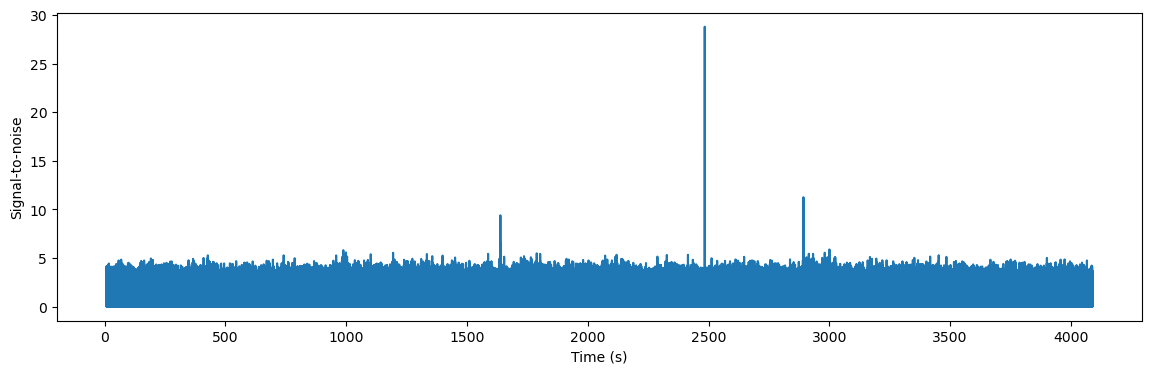

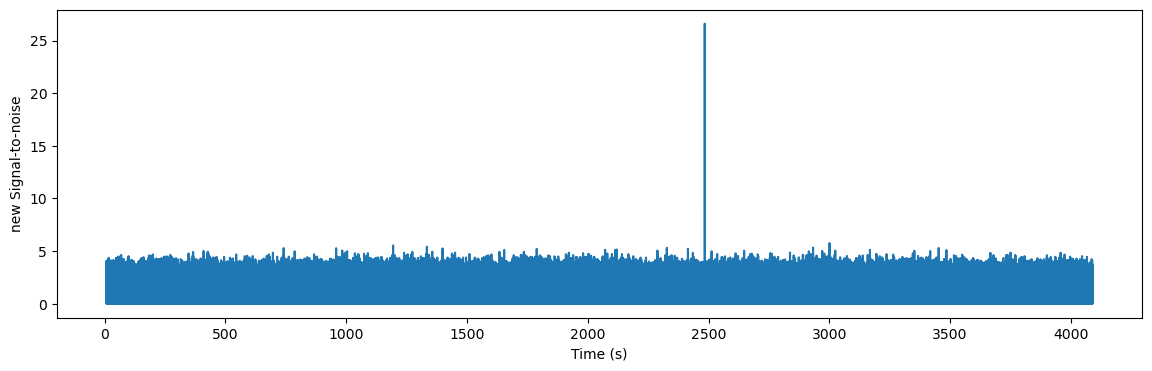

Mass: 10. We found a signal at 2483.96875s with SNR 26.598221577688136


In [3]:
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

# match filtering
snr = matched_filter(hp, ts,
                    psd=psd, low_frequency_cutoff=20)
# snr = snr.crop(4 + 4, 4)                                      #! This was the problem again, in the snr cropping
snr = snr.crop(5, 4)

plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

nbins = 26
chisq = power_chisq(hp, ts, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(5, 4)

dof = nbins * 2 - 2
chisq /= dof
# plt.plot(chisq.sample_times, chisq)
# plt.ylabel(r'$\chi^2$')
# plt.xlabel('Time (s)')
# plt.show()


# The rho-hat term above is named "newsnr" here
nsnr = newsnr(abs(snr), chisq)

peak = nsnr.argmax()
nsnrp = nsnr[peak]
time = snr.sample_times[peak]


plt.plot(snr.sample_times, nsnr)
plt.ylabel('new Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

print("Mass: {}. We found a signal at {}s with SNR {}".format(mass, time, nsnrp))

In [4]:
nsnr.std()

0.6484837029685317

Looking at file challenge3_2048hz.gwf with template mass 10 M_sol


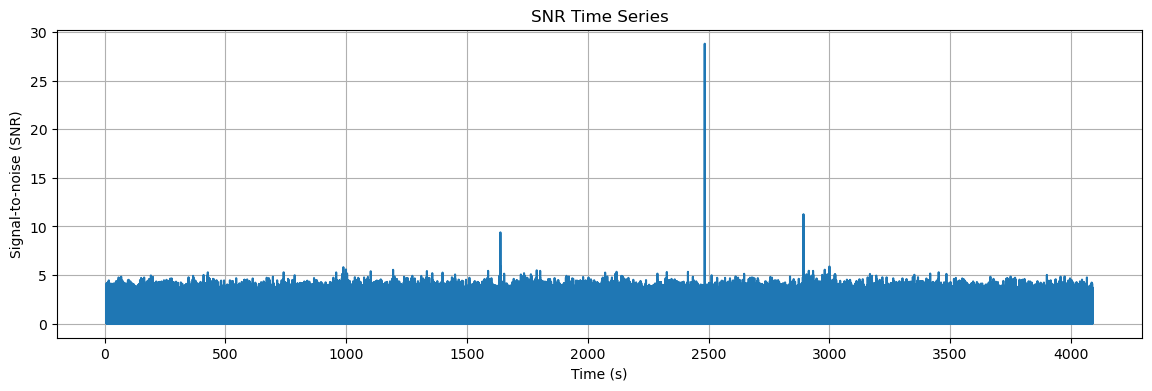

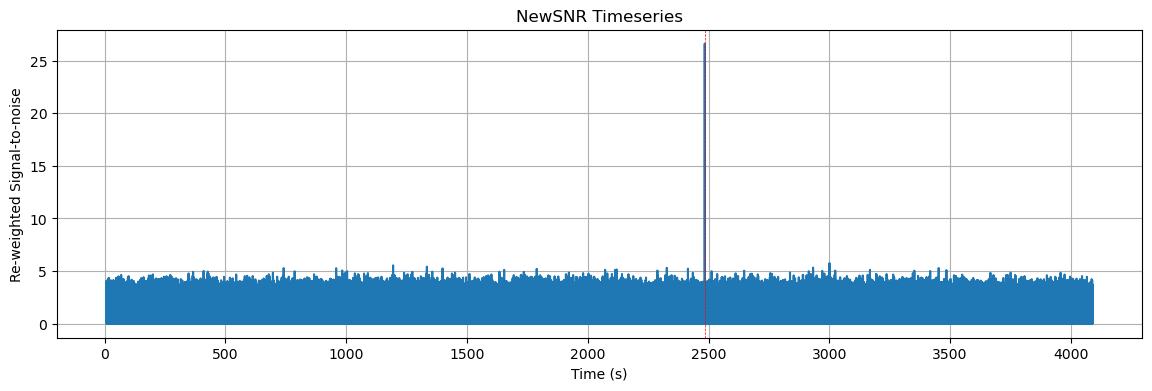

Mass: 10. We found a signal at 2483.96875s with SNR 26.593608828820443


In [7]:
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import matplotlib.pyplot as plt

def challenge_matched_filter(file_name,mass):
    print("Looking at file {} with template mass {} M_sol".format(file_name,mass))
    channel_name = "H1:CHALLENGE3"
    ts = read_frame(file_name, channel_name)
    # conditioned_ts = ts
    ts = highpass(ts, 15.0)
    strain_ts = resample_to_delta_t(ts, 1.0/2048)
    conditioned_ts = strain_ts.crop(2, 2)
    psd_ts = conditioned_ts.psd(4)
    psd_ts = interpolate(psd_ts, conditioned_ts.delta_f)
    psd_ts = inverse_spectrum_truncation(psd_ts, int(4 * conditioned_ts.sample_rate),
    low_frequency_cutoff=15)
    
    # hp_x, _ = get_td_waveform(approximant="IMRPhenomD",
    #                         mass1=mass, mass2=mass,
    #                         f_lower=20.0, delta_t=conditioned_ts.delta_t)
    # hp_x.resize(len(conditioned_ts))
    # print(hp_x.start_time)
    # hp_x = hp_x.cyclic_time_shift(hp_x.start_time)
    
    hp_x, _ = get_fd_waveform(approximant="IMRPhenomD",
                            mass1=mass, mass2=mass,
                            f_lower=20.0, delta_f=conditioned_ts.delta_f)
    hp_x.resize(len(psd_ts))

    # For each observatory use this template to calculate the SNR time series
    snr_x = matched_filter(hp_x, conditioned_ts, psd=psd_ts, low_frequency_cutoff=20).crop(5, 4)

    plt.figure(figsize=[14, 4])
    plt.plot(snr_x.sample_times, abs(snr_x), label='H1')
    plt.title('SNR Time Series')
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Signal-to-noise (SNR)')
    plt.show()

    nbins = 26
    chisq_x = power_chisq(hp_x, conditioned_ts, nbins, psd_ts, low_frequency_cutoff=20.0)
    chisq_x = chisq_x.crop(5, 4)

    dof_x = nbins * 2 - 2
    chisq_x /= dof_x


    # The rho-hat term above is named "newsnr" here
    nsnr_x = newsnr(abs(snr_x), chisq_x)

    peak = nsnr_x.argmax()
    nsnrp_x = nsnr_x[peak]
    time_x = snr_x.sample_times[peak]


    # Plot the new SNR timeseries
    plt.figure(figsize=[14, 4])
    plt.plot(snr_x.sample_times, nsnr_x, label='H1')
    plt.axvline(time_x, color='red', linestyle='--', linewidth=0.5)
    plt.title('NewSNR Timeseries')
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Re-weighted Signal-to-noise')
    plt.show()

    print("Mass: {}. We found a signal at {}s with SNR {}".format(mass, time_x, nsnrp_x))
    
challenge_matched_filter("challenge3_2048hz.gwf", 10)

Use frequency domain template for matching, it is more convenient

IMRPhenomD: fd  
Mass: 10. We found a signal at 2483.96875s with SNR 26.593608828820443

td (start_time = -15.8) corrected  
Mass: 10. We found a signal at 2483.96875s with SNR 26.598221577688197

not_corrected  (found a numerical artifact in snr at right end)  
Mass: 10. We found a signal at 2468.16845703125s with SNR 27.261732825285495

SEOBNRv4_opt: td  
Mass: 10. We found a signal at 2483.96728515625s with SNR 27.22783902442322

fd (not available)